In [1]:
import tensorflow as tf 
tf.test.gpu_device_name()

''

In [2]:
from google.colab import files
upload = files.upload()

Saving 3-class.csv to 3-class.csv


In [3]:
up_list = files.upload()

Saving list.txt to list.txt


In [4]:
!mkdir outputs
!pip3 install keras_metrics

In [0]:
# -*- coding: utf-8 -*-
#-------------------------------------------------------------------------------

import itertools
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt


import re
from keras import regularizers
import sys
import codecs
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.isri import ISRIStemmer
#from nltk.stem.arlstem import ARLSTem
import gensim
from gensim.models.word2vec import Word2Vec


import keras
from keras import layers
from keras import optimizers

from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import text_to_word_sequence
from keras.utils import to_categorical
import keras_metrics
from keras.layers import Embedding
from sklearn.model_selection import train_test_split

from keras.engine.topology import Layer

In [124]:
from keras.utils import get_file
cbow = get_file('cbow_100.zip', 'https://archive.org/download/aravec2.0/tweet_cbow_100.zip', extract=True)
cbow

'/root/.keras/datasets/cbow_100.zip'

In [125]:
!ls /root/.keras/datasets/

cbow_100.zip	 tweets_cbow_100.trainables.syn1neg.npy
tweets_cbow_100  tweets_cbow_100.wv.vectors.npy


In [0]:
from pathlib import Path
cbow_path = Path('/root/.keras/datasets/tweets_cbow_100')

In [0]:
import keras.backend as K
K.clear_session()

In [128]:
data = pd.read_csv('3-class.csv', encoding='utf-8')
data = data.sample(frac=1).reset_index(drop=True)
print(data.shape)
data.head()

(56674, 2)


,Tweet,Polarity
0,العالم المتحضر لم يجرا حتى على ادانه نظام بني...,neg
1,الفتح قاتل طوال المباراه قفل مفاتيح لعب الهلا...,pos
2,لماذا_يا_خوله_العنزي يزعمون ان التبرج والسفور...,neg
3,برشلونه_روما لاول مره اشاهد راس حربه يراقب قل...,pos
4,احساس اني اداوم بكره افضل من احساس فيه امل اج...,neut


In [129]:
data.sample(frac=1)

,Tweet,Polarity
41671,الى متى ياشركه الاتصالات والنت مايسوى فلوس اش...,neg
53619,لماذا_يا_خوله_العنزي وفي كل امر ينقسم الناس ل...,neut
54718,ويجيلكك طحلوب ويقول اناا م اشوف الهلال اكيد مح...,neg
20518,ماظنتي يعلقونه لان مافي امطار الحين تعليق_الدر...,neut
26892,الحكم قال ماراح اصفر الا لمن يسجل الهلال,neut
...,...,...
3111,وعندما تعدى الرافضي نمر النمر على الامير نايف...,neut
47853,هههههههه بعض السعوديين اضل من الحيوانات تستطيع...,neg
29855,فارس عوض الاولى لغيتها بس الثانيه شلون تلغيها...,neg
26074,ما ننسى سوا التحكيم الواضح كان الله في عون ال...,neg


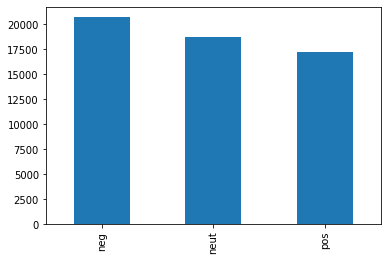

In [130]:
data['Polarity'].value_counts().sort_index().plot.bar()

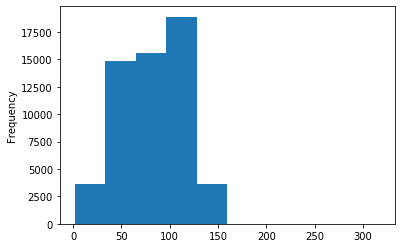

In [131]:
data['Tweet'].str.len().plot.hist()

In [132]:
def transform(x):
    if x == 'neg':
        return 0
    elif x == 'pos':
        return 1
    return 2
data['Sentiment'] = data['Polarity'].apply(transform)
data.head()

,Tweet,Polarity,Sentiment
0,العالم المتحضر لم يجرا حتى على ادانه نظام بني...,neg,0
1,الفتح قاتل طوال المباراه قفل مفاتيح لعب الهلا...,pos,1
2,لماذا_يا_خوله_العنزي يزعمون ان التبرج والسفور...,neg,0
3,برشلونه_روما لاول مره اشاهد راس حربه يراقب قل...,pos,1
4,احساس اني اداوم بكره افضل من احساس فيه امل اج...,neut,2


In [133]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [134]:
#remove users
data['clean'] = data['Tweet'].apply(lambda x: re.sub('(@[A-Za-z]+)', '', x, flags=re.UNICODE))

#remove hashtags
#data['clean'] = data['clean'].apply(lambda x: re.sub('([أ-ي]+_[أ-ي]+)', '', x, flags=re.UNICODE))
#data['clean'] = data['clean'].apply(lambda x: re.sub('(_[أ-ي]+)', '', x, flags=re.UNICODE))
data['clean'] = data['clean'].apply(lambda x: re.sub('(_)', ' ', x, flags=re.UNICODE))
#remove letters, numbers & symbols
data['clean'] = data['clean'].apply(lambda x: re.sub('[a-zA-Z0-9@=$:.،%^*"#~£/&\n؟?!-_]', '', x, flags=re.UNICODE))

#arabic numbers
data['clean'] = data['clean'].apply(lambda x: re.sub('[٠١٢٣٤٥٦٧٨٩]', '', x, flags=re.UNICODE))

#nltk tokenize
data['clean'].apply(word_tokenize)
data['clean'] = data['clean'].apply(word_tokenize) 

#repeated letters
data['clean']= data['clean'].apply(lambda x: [''.join(ch for ch, _ in itertools.groupby(y)) for y in x])

#normalization
def normalizeArabic(text):
    text = re.sub("[إأٱآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "و", text)
    text = re.sub("ئ", "ء", text)
    text = re.sub("ة", "ه", text)
    return(text)
data['clean']= data['clean'].apply(lambda x: [normalizeArabic(y) for y in x])

#remove stopwords
def get_stop_words():
    path = 'list.txt'
    stop_words = []
    with codecs.open(path, "r", encoding="utf-8", errors="ignore") as myfile:
        stop_words = myfile.readlines()
    stop_words = [word.strip() for word in stop_words]
    return stop_words

stop_words = get_stop_words()
data['clean']= data['clean'].apply(lambda x: [item for item in x if item not in stop_words])

#remove emojis
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

data['clean']= data['clean'].apply(lambda x: [remove_emoji(y) for y in x])

data.head(10)

,Tweet,Polarity,Sentiment,clean
0,العالم المتحضر لم يجرا حتى على ادانه نظام بني...,neg,0,"[العالم, المتحضر, يجرا, حتي, ادانه, نظام, بني,..."
1,الفتح قاتل طوال المباراه قفل مفاتيح لعب الهلا...,pos,1,"[الفتح, قاتل, طوال, المباراه, قفل, مفاتيح, لعب..."
2,لماذا_يا_خوله_العنزي يزعمون ان التبرج والسفور...,neg,0,"[لماذا, خوله, العنزي, يزعمون, التبرج, والسفور,..."
3,برشلونه_روما لاول مره اشاهد راس حربه يراقب قل...,pos,1,"[برشلونه, روما, لاول, مره, اشاهد, راس, حربه, ي..."
4,احساس اني اداوم بكره افضل من احساس فيه امل اج...,neut,2,"[احساس, اني, اداوم, بكره, افضل, احساس, امل, اج..."
5,يا خوي انتم نصابين عندنا ما فيه فور جي والسرع...,neg,0,"[خوي, انتم, نصابين, عندنا, فور, جي, والسرعه, ت..."
6,مبروك للهلال هاردلك للاهلي الهلال بطريقته سيف...,pos,1,"[مبروك, لهلال, هاردلك, لاهلي, الهلال, بطريقته,..."
7,الجنوب عامه ابشركم بتتعلق الدراسه بعد بكره لمد...,neut,2,"[الجنوب, عامه, ابشركم, بتعلق, الدراسه, بكره, ل..."
8,تريد تمتلك عقار ولا تستطيع بسبب غلاا الاسعار ا...,neut,2,"[تريد, تمتلك, عقار, تستطيع, بسب, غلا, الاسعار,..."
9,برشلونه_روما برشلونه يتجاهل تاريخ روما ويضرب ...,neg,0,"[برشلونه, روما, برشلونه, يتجاهل, تاريخ, روما, ..."


In [135]:
CBOW = Word2Vec.load(str(cbow_path))
CBOWE = CBOW.wv.get_keras_embedding()

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
y = to_categorical(data['Sentiment'].values)

In [137]:
tokenizer = Tokenizer(num_words=len(data['clean']), split=" ")
tokenizer.fit_on_texts(data['clean'].values)

X = tokenizer.texts_to_sequences(data['clean'].values)
X = pad_sequences(X) # padding our text vector so they all have the same length
X[:5]

array([[    0,     0,     0,     0,     0,     0,     0,   124, 15158,
        24258,    59, 18660,   331,  2448,   177, 18661,  6853,  2112,
           97,    89,    21,  1236,   104,   757],
       [    0,     0,     0,     0,     0,     0,    20,  3315,  3063,
           43,  6854, 18662,   184,     1,   859,  2507, 12976,     1,
          859, 18663, 12976,     1,    20,   414],
       [    0,     0,     0,     0,     0,     0,     0,    48,    66,
           71, 11265,  7434, 11266,   859,  8961,   243, 18664, 24259,
        35697,    34,  1101,   127, 35698, 15159],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     7,     8,  2682,   134,  5516,   758,
         5517, 18665,   799,  1041,   119,  8962],
       [    0,     0,     0,     0,     0,     0,     0,  2957,   215,
         2243,   245,    99,  2957,  1309,   105,  4398,  1415, 24260,
          165, 24261,    26,     4,     5, 11267]], dtype=int32)

In [138]:
X.shape

(56674, 24)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [0]:
#Metrics
def plot_data(H, EPOCHS, name='figure.png'):
    # plot the losses
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, EPOCHS), H['acc'],
        label="Accuracy")
    plt.plot(np.arange(0, EPOCHS), H['val_acc'],
        label="Val_Accuracy")
    plt.plot(np.arange(0, EPOCHS), H['loss'],
        label="Loss")
    plt.plot(np.arange(0, EPOCHS), H['val_loss'],
        label="Val_Loss")
    plt.xlabel("Epoch #")
    plt.ylabel("Accuracy & Loss")
    plt.legend(loc="upper right")
    plt.show()
    if name:
        plt.savefig(name)

In [0]:
#calculation
from keras import backend as K


# calculate f score
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [0]:
# metrics all
metrics = [
    'accuracy',
    keras_metrics.precision(),
    keras_metrics.recall(),
    f1,
]

In [0]:
# hyperparamters
BATCH_SIZE = 32
LEARNING_RATE = 0.001
VALIDATION_SPLIT = 0.2
EPOCHS = 20

In [0]:
#build model
def buildAndRunModel(model, ckpt_path):
    # callbacks
    checkpoints = keras.callbacks.ModelCheckpoint(ckpt_path, monitor='val_loss', save_best_only=True, save_weights_only=False)
    
    model.compile(loss='categorical_crossentropy', 
                   optimizer='adam',
                   metrics=metrics,)
    H = model.fit(X_train, y_train, 
               validation_split=VALIDATION_SPLIT, 
               batch_size=BATCH_SIZE, 
               epochs=EPOCHS,
               callbacks=[checkpoints],)
    return H

In [0]:
def eval_model(model):
    E = model.evaluate(X_test, y_test)
    return list(zip(E, model.metrics_names))

In [0]:

#Bi-GRU

gru_model_input = layers.Input(shape=(X_train.shape[1],))
embed = CBOWE(gru_model_input)

forw = layers.GRU(100, return_sequences=True, dropout=0.5)(embed)
backw = layers.GRU(100, return_sequences=True, go_backwards=True, dropout=0.5)(embed)
link= layers.Concatenate()([forw,backw])

x1 = layers.Flatten()(link)
x2 = layers.Dense(100, activation='relu', name='desne1')(x1)
x3 = layers.Dense(3, activation='softmax', name='desne_output')(x2)

gru_model = keras.models.Model(inputs=gru_model_input, outputs=x3)

In [147]:
gru_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 24)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 24, 100)      33167900    input_1[0][0]                    
__________________________________________________________________________________________________
gru_1 (GRU)                     (None, 24, 100)      60300       embedding_1[0][0]                
__________________________________________________________________________________________________
gru_2 (GRU)                     (None, 24, 100)      60300       embedding_1[0][0]                
____________________________________________________________________________________________

In [148]:
%%time
GRU_H = buildAndRunModel(gru_model, 'gru_ckpt')

Train on 36271 samples, validate on 9068 samples
Epoch 1/20
36271/36271 [==============================] - 66s 2ms/step - loss: 0.9833 - acc: 0.5116 - precision: 0.5789 - recall: 0.2985 - f1: 0.3677 - val_loss: 0.8416 - val_acc: 0.6194 - val_precision: 0.6381 - val_recall: 0.5887 - val_f1: 0.5800
Epoch 2/20
36271/36271 [==============================] - 65s 2ms/step - loss: 0.8665 - acc: 0.6006 - precision: 0.6398 - recall: 0.4884 - f1: 0.5471 - val_loss: 0.8141 - val_acc: 0.6386 - val_precision: 0.6620 - val_recall: 0.6214 - val_f1: 0.6232
Epoch 3/20
36271/36271 [==============================] - 65s 2ms/step - loss: 0.8310 - acc: 0.6222 - precision: 0.6563 - recall: 0.5227 - f1: 0.5798 - val_loss: 0.7744 - val_acc: 0.6576 - val_precision: 0.7177 - val_recall: 0.5587 - val_f1: 0.6410
Epoch 4/20
36271/36271 [==============================] - 65s 2ms/step - loss: 0.8073 - acc: 0.6346 - precision: 0.6753 - recall: 0.5491 - f1: 0.6007 - val_loss: 0.7576 - val_acc: 0.6675 - val_precision: 

In [149]:
eval_model(gru_model)

11335/11335 [==============================] - 4s 388us/step


[(0.7827464448495957, 'loss'),
 (0.6860167622513639, 'acc'),
 (0.6871945258874097, 'precision'),
 (0.674178853975685, 'recall'),
 (0.6769887582709939, 'f1')]

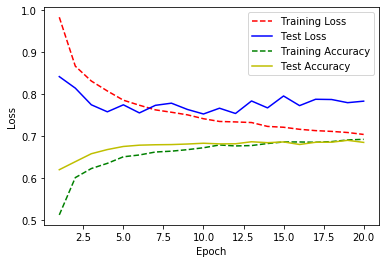

In [150]:
training_loss = GRU_H.history['loss']
test_loss = GRU_H.history['val_loss']
training_acc = GRU_H.history['acc']
test_acc = GRU_H.history['val_acc']
# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.plot(epoch_count, training_acc, 'g--')
plt.plot(epoch_count, test_acc, 'y-')
plt.legend(['Training Loss', 'Test Loss', 'Training Accuracy', 'Test Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();